# Important note

1. This notebook is built upon this quickstarter by https://www.kaggle.com/code/ambrosm/msci-multiome-quickstart

2. It reads the Multime traning data in sparse mode,from this dataset: https://www.kaggle.com/datasets/sbunzini/open-problems-msci-multiome-sparse-matrices

3. During CV this NB reads the whole training dataset,in four chunks. It takes 33 minutes to complete.

4. It uses truncatedSVD for reducing the number of features, to 512.

5. The model is Ridge. I tried LinearRegression and KNN  (very fast) and DecisionTrees, LinearSVD (dual=False),LGBM and CatBoost (excruciatingly slow).

6. The CV is about 0.658, which is not an improvement. 

I hope this helps.

# Multiome Quickstart

This notebook shows how to cross-validate a baseline model and create a submission for the Multiome part of the *Multimodal Single-Cell Integration* competition without running out of memory.

It does not show the EDA - see the separate notebook [MSCI EDA which makes sense ⭐️⭐️⭐️⭐️⭐️](https://www.kaggle.com/ambrosm/msci-eda-which-makes-sense).

The baseline model for the other part of the competition (CITEseq) is [here](https://www.kaggle.com/ambrosm/msci-citeseq-quickstart).

In [1]:
import os, gc, pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from colorama import Fore, Back, Style
from matplotlib.ticker import MaxNLocator
import tensorflow as tf
import scipy.sparse as sps
from scipy.sparse.linalg import lsqr
import math

from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, load_model
from keras import backend as K
from tensorflow.keras.layers import Dropout,Dense, Input, Concatenate
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
from sklearn.decomposition import TruncatedSVD
#from sklearn.preprocessing import StandardScaler, scale
#from sklearn.decomposition import PCA
#from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import Ridge, LinearRegression, Lasso, HuberRegressor
from sklearn.metrics import mean_squared_error

#import lightgbm as lgb
#import catboost as cb
#from catboost import CatBoost,CatBoostRegressor, Pool
#from sklearn.multioutput import MultiOutputRegressor

DATA_DIR = "./data/"
FP_CELL_METADATA = os.path.join(DATA_DIR,"metadata.csv")

FP_CITE_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_cite_inputs.h5")
FP_CITE_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_cite_targets.h5")
FP_CITE_TEST_INPUTS = os.path.join(DATA_DIR,"test_cite_inputs.h5")

FP_MULTIOME_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_multi_inputs.h5")
FP_MULTIOME_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_multi_targets.h5")
FP_MULTIOME_TEST_INPUTS = os.path.join(DATA_DIR,"test_multi_inputs.h5")

FP_SUBMISSION = os.path.join(DATA_DIR,"sample_submission.csv")
FP_EVALUATION_IDS = os.path.join(DATA_DIR,"evaluation_ids.csv")

# The scoring function

It is a slight modification of the original scoring function. No averages.

In [2]:
def correlation_score(y_true, y_pred):
    """Scores the predictions according to the competition rules. 
    
    It is assumed that the predictions are not constant.
    
    Returns the average of each sample's Pearson correlation coefficient"""
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    if y_true.shape != y_pred.shape: raise ValueError("Shapes are different.")
    corrsum = 0
    for i in range(len(y_true)):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
   
    return corrsum, len(y_true)
    #return corrsum / len(y_true)

    
def negative_correlation_loss(y_true, y_pred):
    """Negative correlation loss function for Keras
    
    NO Precondition:
    y_true.mean(axis=1) == 0
    y_true.std(axis=1) == 1
    
    Returns:
    -1 = perfect positive correlation
    1 = totally negative correlation
    """

    my = K.mean(tf.convert_to_tensor(y_pred), axis=1)
    my_true = K.mean(tf.convert_to_tensor(y_true), axis=1)
    my = tf.tile(tf.expand_dims(my, axis=1), (1, K.shape(y_pred)[1]))
    my_true = tf.tile(tf.expand_dims(my_true, axis=1), (1, K.shape(y_true)[1]))
    ym = y_pred - my
    ym_true = y_true - my_true
    r_num = K.sum(tf.multiply(ym_true, ym), axis=1)
    r_den = tf.sqrt(K.sum(K.square(ym), axis=1) * K.sum(K.square(ym_true), axis=1))
    r = tf.reduce_mean(r_num / r_den)
    return - r


# Preprocessing and cross-validation

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
cite_train_x_df = pd.read_hdf(FP_CITE_TRAIN_INPUTS)

In [5]:
cite_train_y_df = pd.read_hdf(FP_CITE_TRAIN_TARGETS)

In [6]:
cite_train_x_raw = cite_train_x_df.values

In [7]:
cite_train_y_raw = cite_train_y_df.values

In [8]:
cite_train_y_raw.shape

(70988, 140)

In [9]:
cite_train_x_raw.shape

(70988, 22050)

In [10]:
results_df = pd.read_csv('cite_train_corr.csv')

In [11]:
results_df

,Unnamed: 0,y_col,x_col,pcorr
0,0,0,0,0.000912
1,1,0,1,0.002799
2,2,0,2,0.056300
3,3,0,3,0.003715
4,4,0,4,0.003666
...,...,...,...,...
3086995,3086995,139,22045,0.011796
3086996,3086996,139,22046,0.031392
3086997,3086997,139,22047,0.051826
3086998,3086998,139,22048,0.051478


In [12]:
results_df = results_df[results_df['pcorr'].notna()]

In [13]:
results_df

,Unnamed: 0,y_col,x_col,pcorr
0,0,0,0,0.000912
1,1,0,1,0.002799
2,2,0,2,0.056300
3,3,0,3,0.003715
4,4,0,4,0.003666
...,...,...,...,...
3086995,3086995,139,22045,0.011796
3086996,3086996,139,22046,0.031392
3086997,3086997,139,22047,0.051826
3086998,3086998,139,22048,0.051478


In [14]:
top100 = results_df.sort_values(['pcorr'],ascending=False).groupby('y_col').head(100)

In [15]:
bot100 = results_df.sort_values(['pcorr'],ascending=True).groupby('y_col').head(100)

In [16]:
top100_idx = top100['x_col'].drop_duplicates().values

In [17]:
bot100_idx = bot100['x_col'].drop_duplicates().values

In [18]:
len(top100_idx)

1481

In [19]:
len(bot100_idx)

1221

In [20]:
p2_idx = results_df[results_df['pcorr']>0.2]['x_col'].drop_duplicates().values

In [21]:
mp2_idx = results_df[results_df['pcorr']<-0.2]['x_col'].drop_duplicates().values

In [22]:
len(p2_idx)

1588

In [23]:
len(mp2_idx)

491

In [24]:
use_idx = list(set(list(top100_idx) + list(bot100_idx) + list(p2_idx) + list(mp2_idx)))

In [25]:
len(use_idx)

2457

In [26]:
cite_train_x_raw = cite_train_x_raw[:,use_idx]

In [27]:
cite_train_x_raw.shape

(70988, 2457)

### Start training

In [28]:
cell_df = pd.read_csv("df_cell.csv")

In [29]:
cell_df = cell_df[['cell_id','day','donor_index']]

In [30]:
cell_df.astype({'day':'float32','donor_index':'float32'})

,cell_id,day,donor_index
0,c2150f55becb,2.0,0.0
1,65b7edf8a4da,2.0,0.0
2,526647a698f8,2.0,0.0
3,ab8f207a3dec,2.0,0.0
4,08df3dcce25c,2.0,0.0
...,...,...,...
281523,96a60b026659,10.0,3.0
281524,d493e546991e,10.0,3.0
281525,05666c99aa48,10.0,3.0
281526,121f946642b5,10.0,3.0


In [31]:
cite_train_x_df.iloc[:,use_idx]

gene_id,ENSG00000175899_A2M,ENSG00000120675_DNAJC15,ENSG00000101152_DNAJC5,ENSG00000116675_DNAJC6,ENSG00000213551_DNAJC9,ENSG00000107331_ABCA2,ENSG00000133119_RFC3,ENSG00000163918_RFC4,ENSG00000005471_ABCB4,ENSG00000175449_RFESD,...,ENSG00000130826_DKC1,ENSG00000107984_DKK1,ENSG00000164741_DLC1,ENSG00000076043_REXO2,ENSG00000126787_DLGAP5,ENSG00000185559_DLK1,ENSG00000201674_RF00012,ENSG00000158856_DMTN,ENSG00000167646_DNAAF3,ENSG00000086061_DNAJA1
cell_id,,,,,,,,,,,,,,,,,,,,,
45006fe3e4c8,0.0,4.774929,0.000000,0.000000,0.000000,4.090185,4.090185,4.090185,0.0,0.000000,...,4.774929,0.0,0.000000,4.090185,0.000000,0.0,0.000000,0.0,0.0,6.154874
d02759a80ba2,0.0,5.126350,0.000000,0.000000,4.039545,0.000000,4.723850,5.126350,0.0,0.000000,...,4.723850,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,5.634798
c016c6b0efa5,0.0,4.529743,0.000000,0.000000,0.000000,0.000000,5.217484,4.931607,0.0,0.000000,...,5.621140,0.0,0.000000,5.907917,0.000000,0.0,3.847321,0.0,0.0,4.529743
ba7f733a4f75,0.0,5.487739,0.000000,0.000000,4.513782,0.000000,4.513782,3.436846,0.0,0.000000,...,5.710055,0.0,3.436846,4.513782,3.436846,0.0,0.000000,0.0,0.0,5.487739
fbcf2443ffb2,0.0,4.597264,0.000000,0.000000,5.689135,0.000000,4.196826,4.196826,0.0,0.000000,...,5.285359,0.0,0.000000,4.882423,4.196826,0.0,0.000000,0.0,0.0,6.380589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650ee456f0f3,0.0,5.774556,0.000000,0.000000,5.084510,0.000000,0.000000,0.000000,0.0,0.000000,...,4.397535,0.0,0.000000,5.084510,0.000000,0.0,0.000000,0.0,0.0,5.084510
cc506e7707f5,0.0,5.067562,0.000000,0.000000,5.757555,0.000000,4.665241,4.665241,0.0,3.981467,...,6.044448,0.0,0.000000,5.067562,4.665241,0.0,0.000000,0.0,0.0,6.044448
a91f1b55a520,0.0,5.407283,0.000000,4.899442,5.185260,0.000000,4.899442,5.185260,0.0,0.000000,...,5.407283,0.0,0.000000,4.899442,0.000000,0.0,4.497696,0.0,0.0,5.407283


In [32]:
cite_train_x_df = cite_train_x_df.iloc[:,use_idx].merge(cell_df, how='left',left_on='cell_id', right_on='cell_id').set_index('cell_id')

In [33]:
cite_train_x_raw = cite_train_x_df.values

In [34]:
cite_train_y_raw = cite_train_y_df.values

In [35]:
del cite_train_x_df,cite_train_y_df

In [36]:
gc.collect()

0

In [37]:
cite_train_y_raw.shape

(70988, 140)

In [38]:
cite_train_x_raw.shape

(70988, 2459)

In [39]:
lam = 0.00

class CorrelationLoss_new(tf.keras.losses.Loss):
    
    def call(self, y_true, y_pred):
        return negative_correlation_loss(y_true, y_pred) + lam * tf.keras.losses.MeanSquaredError()(y_true,y_pred)

In [40]:
class CorrelationLoss_pure(tf.keras.losses.Loss):
    
    def call(self, y_true, y_pred):
        return negative_correlation_loss(y_true, y_pred)

In [41]:
class CorrelationMetric(tf.keras.metrics.Mean):
    def __init__(self, name='correlation_metric', **kwargs):
        super(CorrelationMetric, self).__init__(name=name, **kwargs)
        self.correlation = self.add_weight(name='corr', initializer='zeros')
    def update_state(self, y_true, y_pred, **kwargs):
        corr =  - negative_correlation_loss(y_true, y_pred)/1996
        super().update_state(corr, **kwargs)
        self.correlation.assign_add(corr)
    def result(self):
        return self.correlation


In [42]:
class MultiomeSequence(tf.keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size=64):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return self.x.shape[0] // self.batch_size

    def __getitem__(self, idx):
        """
        Return the idx-th batch
        """

        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

In [43]:
class MultiomeSequence_test(tf.keras.utils.Sequence):

    def __init__(self, x_set, batch_size=64):
        self.x= x_set
        self.batch_size = batch_size

    def __len__(self):
        return self.x.shape[0] // self.batch_size

    def __getitem__(self, idx):
        """
        Return the idx-th batch
        """

        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x
        

## First go without any dropout, when validation and training have the same loss, turn on the dropout.

In [44]:
def my_model(input_size = 200, output_size = 200, middle_size = 100, layer_num = 4, init_dropout = 0.2, layer_dropout=0.2, activation = 'swish'):
    """Sequential neural network
    
    Returns a compiled instance of tensorflow.keras.models.Model.
    """

    inputs = Input(shape=(input_size, ))
    vip_inputs = tf.slice(inputs, [0, input_size - 2], [-1,2])
    
    inputs_dropout = Dropout(init_dropout)(inputs)
    
    
    layers = [inputs_dropout]
    for i in range(layer_num - 1):
        layers.append(Concatenate()([Dropout(layer_dropout)(Dense(middle_size-2, activation=activation)(layers[i])), vip_inputs]))
    last_layer = Dense(output_size)(layers[-1])

    regressor = Model(inputs, last_layer)
    
    return regressor

In [45]:
def my_model_2(input_size = 200, output_size = 200, middle_size = 100, layer_num = 4, init_dropout = 0.2, layer_dropout=0.2, activation = 'swish'):
    """Sequential neural network
    
    Returns a compiled instance of tensorflow.keras.models.Model.
    """

    inputs = Input(shape=(input_size, ))
    vip_inputs = tf.slice(inputs, [0, input_size - 2], [-1,2])
    
    inputs_dropout = Dropout(init_dropout)(inputs)
    
    
    layers = [inputs_dropout]
    for i in range(layer_num - 1):
        layers.append(Concatenate()([Dropout(layer_dropout-0.1*i)(Dense(middle_size-2, activation=activation)(layers[i])), vip_inputs]))
    last_layer = Dense(output_size)(layers[-1])

    regressor = Model(inputs, last_layer)
    
    return regressor

In [59]:
%%time
# Cross-validation
# multi_train_x = multi_train_x_raw
# multi_train_y = multi_train_y_raw
gc.collect()
K.clear_session()
model = None
model = my_model_2(cite_train_x_raw.shape[1], cite_train_y_raw.shape[1], 4096, 4, init_dropout=0.2, layer_dropout=0.7, activation='selu')
print(model.summary())
model.compile(tf.keras.optimizers.Adam(learning_rate=0.001),loss = CorrelationLoss_new())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2459)]       0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2459)         0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 4094)         10071240    dropout[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4094)         0           dense[0][0]                      
______________________________________________________________________________________________

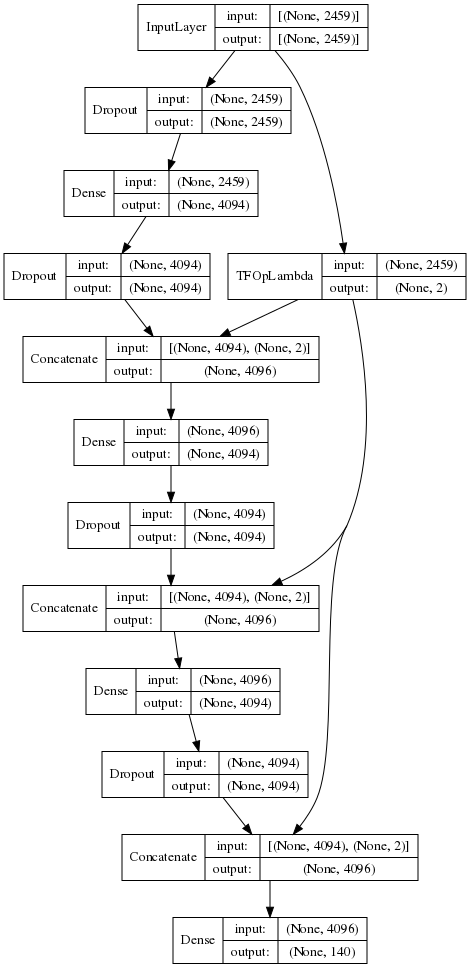

In [60]:
display(plot_model(model, show_layer_names=False, show_shapes=True, dpi=72))

In [58]:
# model.load_weights("./model/cite_2048_3_p8_goodloss_test")

In [49]:
kf = KFold(n_splits = 9, shuffle = True, random_state=23)
score_list = []
b_size = 4096
idx_tr, idx_va = next(kf.split(cite_train_x_raw))

In [50]:
cite_train_x_raw.shape

(70988, 2459)

In [51]:
training_generator = MultiomeSequence(cite_train_x_raw[idx_tr], cite_train_y_raw[idx_tr], batch_size=b_size)
validation_generator = MultiomeSequence(cite_train_x_raw[idx_va], cite_train_y_raw[idx_va], batch_size=b_size)
retraining_generator = MultiomeSequence(cite_train_x_raw, cite_train_y_raw, batch_size=b_size)

In [52]:
gc.collect()

4808

### Next time try "swish" as activation function.

In [62]:
# checkpoint_filepath = './cite_v31/checkpoint{epoch:02d}'
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor='loss', save_freq=1996*11, save_best_only=False, mode='auto')

In [63]:
# epoc = 100
# train_hist = model.fit(retraining_generator, validation_data=validation_generator, batch_size=b_size,epochs=epoc, verbose=1,validation_freq=5, callbacks=[model_checkpoint_callback])

In [53]:
epoc = 700
train_hist = model.fit(training_generator, validation_data=validation_generator, batch_size=b_size,epochs=epoc, verbose=1,validation_freq=5)

Epoch 1/700
15/15 [==============================] - 3s 167ms/step - loss: -0.7336
Epoch 2/700
15/15 [==============================] - 3s 166ms/step - loss: -0.8010
Epoch 3/700
15/15 [==============================] - 3s 166ms/step - loss: -0.8024
Epoch 4/700
15/15 [==============================] - 3s 167ms/step - loss: -0.8032
Epoch 5/700
15/15 [==============================] - 3s 183ms/step - loss: -0.8028 - val_loss: -0.8101
Epoch 6/700
15/15 [==============================] - 3s 168ms/step - loss: -0.8030
Epoch 7/700
15/15 [==============================] - 3s 170ms/step - loss: -0.8032
Epoch 8/700
15/15 [==============================] - 3s 170ms/step - loss: -0.8039
Epoch 9/700
15/15 [==============================] - 3s 171ms/step - loss: -0.8042
Epoch 10/700
15/15 [==============================] - 3s 179ms/step - loss: -0.8040 - val_loss: -0.8113
Epoch 11/700
15/15 [==============================] - 3s 171ms/step - loss: -0.8047
Epoch 12/700
15/15 [=========================

15/15 [==============================] - 3s 170ms/step - loss: -0.8939
Epoch 95/700
15/15 [==============================] - 3s 183ms/step - loss: -0.8940 - val_loss: -0.8994
Epoch 96/700
15/15 [==============================] - 3s 171ms/step - loss: -0.8936
Epoch 97/700
15/15 [==============================] - 3s 176ms/step - loss: -0.8938
Epoch 98/700
15/15 [==============================] - 3s 172ms/step - loss: -0.8939
Epoch 99/700
15/15 [==============================] - 3s 172ms/step - loss: -0.8943
Epoch 100/700
15/15 [==============================] - 3s 180ms/step - loss: -0.8949 - val_loss: -0.9003
Epoch 101/700
15/15 [==============================] - 3s 173ms/step - loss: -0.8947
Epoch 102/700
15/15 [==============================] - 3s 173ms/step - loss: -0.8947
Epoch 103/700
15/15 [==============================] - 3s 169ms/step - loss: -0.8947
Epoch 104/700
15/15 [==============================] - 3s 169ms/step - loss: -0.8949
Epoch 105/700
15/15 [=======================

15/15 [==============================] - 3s 170ms/step - loss: -0.8995
Epoch 187/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9000
Epoch 188/700
15/15 [==============================] - 3s 169ms/step - loss: -0.8998
Epoch 189/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9004
Epoch 190/700
15/15 [==============================] - 3s 176ms/step - loss: -0.9002 - val_loss: -0.9032
Epoch 191/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9006
Epoch 192/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9010
Epoch 193/700
15/15 [==============================] - 3s 169ms/step - loss: -0.9006
Epoch 194/700
15/15 [==============================] - 3s 170ms/step - loss: -0.8991
Epoch 195/700
15/15 [==============================] - 3s 177ms/step - loss: -0.8998 - val_loss: -0.9022
Epoch 196/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9002
Epoch 197/700
15/15 [==================

15/15 [==============================] - 3s 170ms/step - loss: -0.9022
Epoch 279/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9020
Epoch 280/700
15/15 [==============================] - 3s 177ms/step - loss: -0.9026 - val_loss: -0.9039
Epoch 281/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9032
Epoch 282/700
15/15 [==============================] - 3s 169ms/step - loss: -0.9030
Epoch 283/700
15/15 [==============================] - 3s 169ms/step - loss: -0.9030
Epoch 284/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9032
Epoch 285/700
15/15 [==============================] - 3s 177ms/step - loss: -0.9029 - val_loss: -0.9035
Epoch 286/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9019
Epoch 287/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9027
Epoch 288/700
15/15 [==============================] - 3s 169ms/step - loss: -0.9030
Epoch 289/700
15/15 [==================

15/15 [==============================] - 3s 179ms/step - loss: -0.9050 - val_loss: -0.9035
Epoch 371/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9047
Epoch 372/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9051
Epoch 373/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9053
Epoch 374/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9052
Epoch 375/700
15/15 [==============================] - 3s 177ms/step - loss: -0.9054 - val_loss: -0.9038
Epoch 376/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9048
Epoch 377/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9051
Epoch 378/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9051
Epoch 379/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9047
Epoch 380/700
15/15 [==============================] - 3s 177ms/step - loss: -0.9040 - val_loss: -0.9038
Epoch 381/700
15/15

15/15 [==============================] - 3s 170ms/step - loss: -0.9061
Epoch 463/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9066
Epoch 464/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9064
Epoch 465/700
15/15 [==============================] - 3s 177ms/step - loss: -0.9065 - val_loss: -0.9035
Epoch 466/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9067
Epoch 467/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9068
Epoch 468/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9070
Epoch 469/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9071
Epoch 470/700
15/15 [==============================] - 3s 177ms/step - loss: -0.9071 - val_loss: -0.9038
Epoch 471/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9068
Epoch 472/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9070
Epoch 473/700
15/15 [==================

15/15 [==============================] - 3s 170ms/step - loss: -0.9087
Epoch 555/700
15/15 [==============================] - 3s 177ms/step - loss: -0.9087 - val_loss: -0.9043
Epoch 556/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9085
Epoch 557/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9087
Epoch 558/700
15/15 [==============================] - 3s 183ms/step - loss: -0.9089
Epoch 559/700
15/15 [==============================] - 3s 180ms/step - loss: -0.9090
Epoch 560/700
15/15 [==============================] - 3s 189ms/step - loss: -0.9090 - val_loss: -0.9044
Epoch 561/700
15/15 [==============================] - 3s 182ms/step - loss: -0.9086
Epoch 562/700
15/15 [==============================] - 3s 177ms/step - loss: -0.9089
Epoch 563/700
15/15 [==============================] - 3s 175ms/step - loss: -0.9091
Epoch 564/700
15/15 [==============================] - 3s 175ms/step - loss: -0.9091
Epoch 565/700
15/15 [==================

15/15 [==============================] - 3s 170ms/step - loss: -0.9104
Epoch 647/700
15/15 [==============================] - 3s 171ms/step - loss: -0.9102
Epoch 648/700
15/15 [==============================] - 3s 171ms/step - loss: -0.9099
Epoch 649/700
15/15 [==============================] - 3s 171ms/step - loss: -0.9097
Epoch 650/700
15/15 [==============================] - 3s 184ms/step - loss: -0.9093 - val_loss: -0.9038
Epoch 651/700
15/15 [==============================] - 3s 176ms/step - loss: -0.9094
Epoch 652/700
15/15 [==============================] - 3s 175ms/step - loss: -0.9097
Epoch 653/700
15/15 [==============================] - 3s 175ms/step - loss: -0.9100
Epoch 654/700
15/15 [==============================] - 3s 175ms/step - loss: -0.9100
Epoch 655/700
15/15 [==============================] - 3s 182ms/step - loss: -0.9102 - val_loss: -0.9039
Epoch 656/700
15/15 [==============================] - 3s 176ms/step - loss: -0.9103
Epoch 657/700
15/15 [==================

In [54]:
model.save("./model/cite_31")

INFO:tensorflow:Assets written to: ./model/cite_31/assets


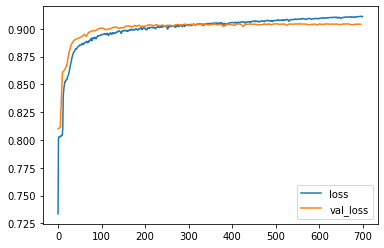

In [55]:
plt.plot(list(range(epoc)),np.array(train_hist.history['loss'])*(-1),label='loss')
plt.plot(list(range(0,epoc,5)),np.array(train_hist.history['val_loss'])*(-1),label='val_loss')
plt.legend(['loss', 'val_loss'])

In [56]:
train_hist.history

{'loss': [-0.7335689663887024,
  -0.8010342121124268,
  -0.8023677468299866,
  -0.8032484650611877,
  -0.8028380870819092,
  -0.8029667139053345,
  -0.8032220005989075,
  -0.8039222359657288,
  -0.8041880130767822,
  -0.8039605617523193,
  -0.8047475814819336,
  -0.8130787014961243,
  -0.8397698998451233,
  -0.8448416590690613,
  -0.848233163356781,
  -0.8508787751197815,
  -0.8526929616928101,
  -0.8525875210762024,
  -0.8533704876899719,
  -0.8542361855506897,
  -0.8545591831207275,
  -0.8546510338783264,
  -0.8573809266090393,
  -0.8578630089759827,
  -0.8586999177932739,
  -0.8607147336006165,
  -0.8623567223548889,
  -0.8641358613967896,
  -0.8665072917938232,
  -0.8685563206672668,
  -0.8698123097419739,
  -0.8721076846122742,
  -0.8742893934249878,
  -0.8747877478599548,
  -0.8770555853843689,
  -0.8780686259269714,
  -0.8790897727012634,
  -0.879321277141571,
  -0.8799529671669006,
  -0.8811889886856079,
  -0.8818284273147583,
  -0.8820561766624451,
  -0.8817805647850037,
  -0.

### Training the whole dataset for submitting results

In [61]:
epoc = 700
train_hist = model.fit(training_generator, validation_data=validation_generator, batch_size=b_size,epochs=epoc, verbose=1,validation_freq=5)

Epoch 1/700
15/15 [==============================] - 3s 171ms/step - loss: -0.7368
Epoch 2/700
15/15 [==============================] - 3s 169ms/step - loss: -0.8001
Epoch 3/700
15/15 [==============================] - 3s 169ms/step - loss: -0.8026
Epoch 4/700
15/15 [==============================] - 3s 170ms/step - loss: -0.8019
Epoch 5/700
15/15 [==============================] - 3s 185ms/step - loss: -0.8030 - val_loss: -0.8114
Epoch 6/700
15/15 [==============================] - 3s 179ms/step - loss: -0.8036
Epoch 7/700
15/15 [==============================] - 3s 177ms/step - loss: -0.8035
Epoch 8/700
15/15 [==============================] - 3s 180ms/step - loss: -0.8039
Epoch 9/700
15/15 [==============================] - 3s 184ms/step - loss: -0.8041
Epoch 10/700
15/15 [==============================] - 3s 183ms/step - loss: -0.8047 - val_loss: -0.8128
Epoch 11/700
15/15 [==============================] - 3s 177ms/step - loss: -0.8121
Epoch 12/700
15/15 [=========================

15/15 [==============================] - 3s 171ms/step - loss: -0.8941
Epoch 95/700
15/15 [==============================] - 3s 177ms/step - loss: -0.8939 - val_loss: -0.8977
Epoch 96/700
15/15 [==============================] - 3s 170ms/step - loss: -0.8945
Epoch 97/700
15/15 [==============================] - 3s 170ms/step - loss: -0.8943
Epoch 98/700
15/15 [==============================] - 3s 171ms/step - loss: -0.8945
Epoch 99/700
15/15 [==============================] - 3s 171ms/step - loss: -0.8947
Epoch 100/700
15/15 [==============================] - 3s 177ms/step - loss: -0.8947 - val_loss: -0.9000
Epoch 101/700
15/15 [==============================] - 3s 170ms/step - loss: -0.8949
Epoch 102/700
15/15 [==============================] - 3s 170ms/step - loss: -0.8946
Epoch 103/700
15/15 [==============================] - 3s 170ms/step - loss: -0.8935
Epoch 104/700
15/15 [==============================] - 3s 171ms/step - loss: -0.8939
Epoch 105/700
15/15 [=======================

15/15 [==============================] - 3s 173ms/step - loss: -0.8990
Epoch 187/700
15/15 [==============================] - 3s 183ms/step - loss: -0.8994
Epoch 188/700
15/15 [==============================] - 3s 181ms/step - loss: -0.8993
Epoch 189/700
15/15 [==============================] - 3s 178ms/step - loss: -0.8992
Epoch 190/700
15/15 [==============================] - 3s 183ms/step - loss: -0.9002 - val_loss: -0.9029
Epoch 191/700
15/15 [==============================] - 3s 183ms/step - loss: -0.9004
Epoch 192/700
15/15 [==============================] - 3s 180ms/step - loss: -0.9003
Epoch 193/700
15/15 [==============================] - 3s 182ms/step - loss: -0.9001
Epoch 194/700
15/15 [==============================] - 3s 175ms/step - loss: -0.9004
Epoch 195/700
15/15 [==============================] - 3s 185ms/step - loss: -0.9005 - val_loss: -0.9031
Epoch 196/700
15/15 [==============================] - 3s 176ms/step - loss: -0.9009
Epoch 197/700
15/15 [==================

15/15 [==============================] - 3s 171ms/step - loss: -0.9030
Epoch 279/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9025
Epoch 280/700
15/15 [==============================] - 3s 178ms/step - loss: -0.9017 - val_loss: -0.9032
Epoch 281/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9023
Epoch 282/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9028
Epoch 283/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9031
Epoch 284/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9026
Epoch 285/700
15/15 [==============================] - 3s 177ms/step - loss: -0.9029 - val_loss: -0.9036
Epoch 286/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9032
Epoch 287/700
15/15 [==============================] - 3s 171ms/step - loss: -0.9031
Epoch 288/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9028
Epoch 289/700
15/15 [==================

15/15 [==============================] - 3s 178ms/step - loss: -0.9048 - val_loss: -0.9043
Epoch 371/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9052
Epoch 372/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9055
Epoch 373/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9056
Epoch 374/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9057
Epoch 375/700
15/15 [==============================] - 3s 177ms/step - loss: -0.9055 - val_loss: -0.9044
Epoch 376/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9058
Epoch 377/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9057
Epoch 378/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9054
Epoch 379/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9057
Epoch 380/700
15/15 [==============================] - 3s 177ms/step - loss: -0.9057 - val_loss: -0.9040
Epoch 381/700
15/15

15/15 [==============================] - 3s 181ms/step - loss: -0.9073
Epoch 463/700
15/15 [==============================] - 3s 176ms/step - loss: -0.9074
Epoch 464/700
15/15 [==============================] - 3s 173ms/step - loss: -0.9074
Epoch 465/700
15/15 [==============================] - 3s 179ms/step - loss: -0.9076 - val_loss: -0.9045
Epoch 466/700
15/15 [==============================] - 3s 172ms/step - loss: -0.9077
Epoch 467/700
15/15 [==============================] - 3s 173ms/step - loss: -0.9076
Epoch 468/700
15/15 [==============================] - 3s 173ms/step - loss: -0.9077
Epoch 469/700
15/15 [==============================] - 3s 174ms/step - loss: -0.9076
Epoch 470/700
15/15 [==============================] - 3s 181ms/step - loss: -0.9077 - val_loss: -0.9039
Epoch 471/700
15/15 [==============================] - 3s 171ms/step - loss: -0.9076
Epoch 472/700
15/15 [==============================] - 3s 171ms/step - loss: -0.9077
Epoch 473/700
15/15 [==================

15/15 [==============================] - 3s 171ms/step - loss: -0.9089
Epoch 555/700
15/15 [==============================] - 3s 177ms/step - loss: -0.9090 - val_loss: -0.9042
Epoch 556/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9091
Epoch 557/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9091
Epoch 558/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9089
Epoch 559/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9090
Epoch 560/700
15/15 [==============================] - 3s 177ms/step - loss: -0.9090 - val_loss: -0.9041
Epoch 561/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9090
Epoch 562/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9086
Epoch 563/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9090
Epoch 564/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9093
Epoch 565/700
15/15 [==================

15/15 [==============================] - 3s 170ms/step - loss: -0.9105
Epoch 647/700
15/15 [==============================] - 3s 172ms/step - loss: -0.9099
Epoch 648/700
15/15 [==============================] - 3s 171ms/step - loss: -0.9097
Epoch 649/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9099
Epoch 650/700
15/15 [==============================] - 3s 188ms/step - loss: -0.9097 - val_loss: -0.9039
Epoch 651/700
15/15 [==============================] - 3s 177ms/step - loss: -0.9101
Epoch 652/700
15/15 [==============================] - 3s 175ms/step - loss: -0.9103
Epoch 653/700
15/15 [==============================] - 3s 174ms/step - loss: -0.9104
Epoch 654/700
15/15 [==============================] - 3s 175ms/step - loss: -0.9101
Epoch 655/700
15/15 [==============================] - 3s 182ms/step - loss: -0.9104 - val_loss: -0.9042
Epoch 656/700
15/15 [==============================] - 3s 175ms/step - loss: -0.9105
Epoch 657/700
15/15 [==================

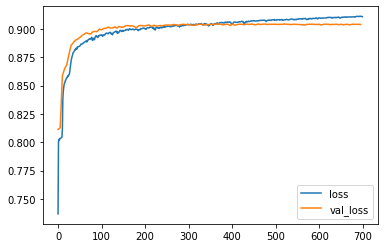

In [62]:
plt.plot(list(range(epoc)),np.array(train_hist.history['loss'])*(-1),label='loss')
plt.plot(list(range(0,epoc,5)),np.array(train_hist.history['val_loss'])*(-1),label='val_loss')
plt.legend(['loss', 'val_loss'])

In [63]:
train_hist.history

{'loss': [-0.7367607355117798,
  -0.8001192212104797,
  -0.8025668263435364,
  -0.801935613155365,
  -0.8029542565345764,
  -0.8035606741905212,
  -0.8035289645195007,
  -0.8038690090179443,
  -0.8041219115257263,
  -0.8047205805778503,
  -0.8120647668838501,
  -0.838061511516571,
  -0.8448390960693359,
  -0.8484242558479309,
  -0.8509435653686523,
  -0.8523496985435486,
  -0.8529779314994812,
  -0.854690670967102,
  -0.8550135493278503,
  -0.8564865589141846,
  -0.8568710088729858,
  -0.8570091724395752,
  -0.8585063219070435,
  -0.8580782413482666,
  -0.8588749766349792,
  -0.8597640991210938,
  -0.8599523305892944,
  -0.8629052042961121,
  -0.8662265539169312,
  -0.8688338398933411,
  -0.8718279004096985,
  -0.8736007213592529,
  -0.8754385113716125,
  -0.8766252994537354,
  -0.8783309459686279,
  -0.8792921900749207,
  -0.8795467615127563,
  -0.8804367184638977,
  -0.8811635971069336,
  -0.8818959593772888,
  -0.8817713260650635,
  -0.8828993439674377,
  -0.8829236626625061,
  -0.8

In [64]:
# del model
gc.collect()
K.clear_session()


In [65]:
cite_train_x_gen = MultiomeSequence_test(cite_train_x_raw, batch_size=4)
train_pred_y = model.predict(cite_train_x_gen)

In [66]:
train_pred_y.shape

(70988, 140)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7ad52551d0>]],
      dtype=object)

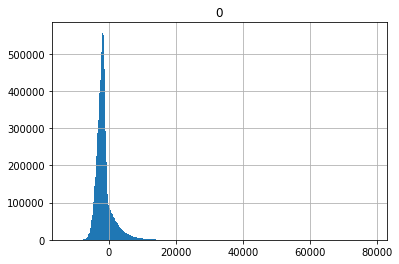

In [67]:
pd.DataFrame(train_pred_y.reshape(-1)).hist(bins=500)
# plt.xlim(-5,20)

(-5, 20)

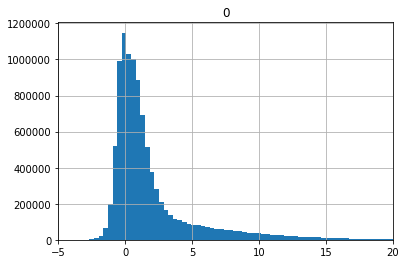

In [68]:
pd.DataFrame(cite_train_y_raw.reshape(-1)).hist(bins=500)
plt.xlim(-5,20)

In [69]:
CorrelationLoss_new()(train_pred_y, cite_train_y_raw)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.91729355>

In [70]:
CorrelationLoss_pure()(train_pred_y, cite_train_y_raw)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.91729355>

### So we have shown that the new loss function is correct.

# Predicting

In [71]:
cite_test_df = pd.read_hdf(FP_CITE_TEST_INPUTS)

In [72]:
cite_test_df = cite_test_df.iloc[:,use_idx].merge(cell_df, how='left',left_on='cell_id', right_on='cell_id').set_index('cell_id')

In [73]:
cite_test_x = cite_test_df.values

In [74]:
cite_test_x.shape

(48663, 2459)

In [75]:
cite_test_x_gen = MultiomeSequence_test(cite_test_x, batch_size=9)

In [76]:
test_pred = model.predict(cite_test_x_gen)

In [77]:
test_pred.shape

(48663, 140)

In [78]:
test_pred

array([[-2534.6394 , -2436.6135 , -2115.232  , ..., -2391.5212 ,
        -1039.0148 , -1385.1445 ],
       [-2964.1914 , -2840.3074 , -2474.343  , ..., -2812.2202 ,
         -818.24866, -1637.9093 ],
       [-2196.2922 , -1928.8136 , -1737.5376 , ..., -2137.4692 ,
         1997.8835 ,  -853.2351 ],
       ...,
       [-8468.326  , -4460.5835 , -6455.4546 , ..., -8236.443  ,
        -7734.942  , -2608.55   ],
       [-2359.5156 , -2056.1753 , -1604.2195 , ..., -2124.9841 ,
         2504.2388 ,   891.0915 ],
       [-2602.4817 , -2251.2864 , -1836.211  , ..., -2408.3481 ,
         2710.3796 ,  1291.7213 ]], dtype=float32)

In [79]:
# test_pred = test_pred/10000

In [80]:
gc.collect()

36294

In [81]:
submission_prev = pd.read_csv('submission 804 NN.csv')['target']

In [82]:
submission_prev

0           9.460453e-02
1          -1.623624e-01
2          -4.053319e-01
3          -3.025821e-01
4           1.114355e+00
                ...     
65744175    9.840503e+09
65744176    0.000000e+00
65744177    0.000000e+00
65744178    1.860109e+09
65744179    9.638013e+09
Name: target, Length: 65744180, dtype: float64

In [83]:
submission_prev = submission_prev.astype('float32')

In [84]:
submission_prev[:len(test_pred.ravel())] = test_pred.ravel()

In [85]:
submission_prev

0          -2.534639e+03
1          -2.436614e+03
2          -2.115232e+03
3           4.738361e+02
4           1.414220e+03
                ...     
65744175    9.840503e+09
65744176    0.000000e+00
65744177    0.000000e+00
65744178    1.860109e+09
65744179    9.638013e+09
Name: target, Length: 65744180, dtype: float32

In [86]:
submission_prev.index.name="row_id"

In [87]:
submission_prev

row_id
0          -2.534639e+03
1          -2.436614e+03
2          -2.115232e+03
3           4.738361e+02
4           1.414220e+03
                ...     
65744175    9.840503e+09
65744176    0.000000e+00
65744177    0.000000e+00
65744178    1.860109e+09
65744179    9.638013e+09
Name: target, Length: 65744180, dtype: float32

In [88]:
submission_prev.to_csv("submission.csv")